# Tutorial 1 — Cross-Sectional Momentum

## Overview

Cross-sectional momentum is among the most robust anomalies in empirical
finance (Jegadeesh & Titman, 1993): stocks with **high recent returns** tend
to continue outperforming over 3–12 months, while **recent losers** lag.

This tutorial covers:
1. Signal definition — the "12 minus 1" convention.
2. Normalisation — rank vs z-score.
3. Portfolio construction — quintile long/short.
4. Backtest & diagnostics on **real US equity data** (via yfinance).
5. What can go wrong — crashes, crowding, regime sensitivity.

## 1. Setup and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (12, 5), "figure.dpi": 100,
                     "axes.grid": True, "grid.alpha": 0.3})

from qlab.data import YFinanceProvider, ParquetCache
from qlab.features import simple_returns, log_returns, rank, zscore, winsorize
from qlab.features import realized_volatility
from qlab.alphas import momentum, short_term_reversal, trend_strength
from qlab.portfolio import equal_weight_long_short, normalize_weights, apply_position_limits
from qlab.backtest import run_backtest, BacktestConfig
from qlab.risk import performance_summary, drawdown_series, drawdown_details, factor_regression

TICKERS = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META",
    "JPM", "GS", "BAC",
    "JNJ", "PFE", "UNH",
    "XOM", "CVX",
    "PG", "KO", "WMT",
    "HD", "NKE",
    "CAT", "HON",
]
START, END = "2018-01-01", "2024-12-31"

provider = ParquetCache(YFinanceProvider(), cache_dir=".qlab_cache")
prices = provider.fetch(TICKERS, START, END)
close = prices["adj_close"]
print(f"Universe : {close.index.get_level_values('ticker').nunique()} stocks")
print(f"Date range: {close.index.get_level_values('date').min().date()} to "
      f"{close.index.get_level_values('date').max().date()}")
print(f"Total obs : {len(close):,}")

Universe : 20 stocks
Date range: 2018-01-02 to 2024-12-30
Total obs : 35,200


## 2. Signal definition

### The "12 minus 1" convention

| Window | Effect | Sign |
|--------|--------|------|
| Months 2–12 | Intermediate momentum | Positive autocorrelation |
| Month 1 (most recent) | Short-term reversal | *Negative* autocorrelation |

$$\text{MOM}_{t} = \frac{P_{t-21}}{P_{t-252}} - 1$$

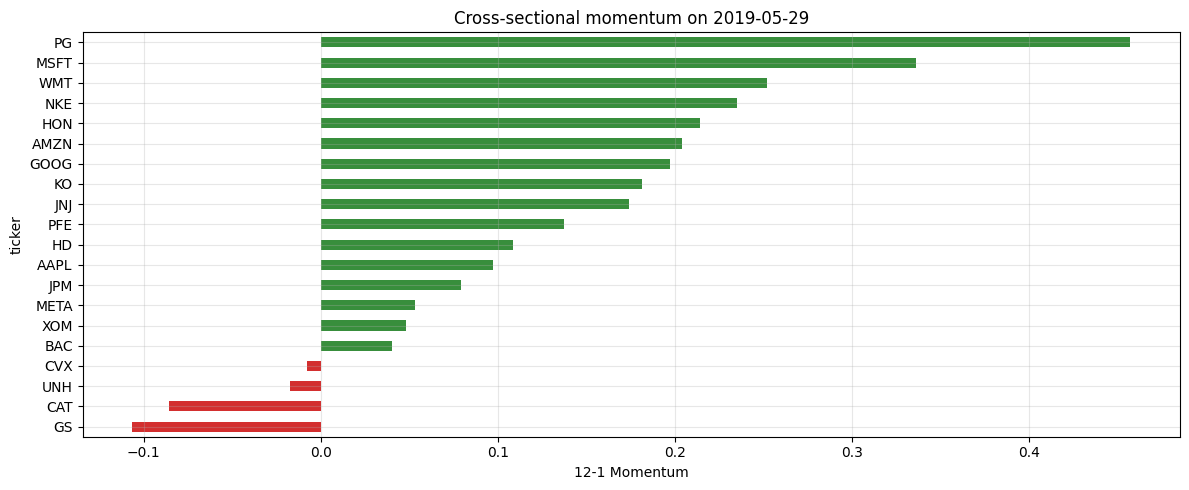

Spread (top - bottom): 0.563


In [2]:
raw_mom = momentum(close, lookback=252, skip=21)
sample_date = raw_mom.dropna().index.get_level_values("date").unique()[100]
cross = raw_mom.loc[sample_date].sort_values()

fig, ax = plt.subplots()
cross.plot.barh(ax=ax, color=["#d32f2f" if v < 0 else "#388e3c" for v in cross.values])
ax.set_xlabel("12-1 Momentum")
ax.set_title(f"Cross-sectional momentum on {sample_date.date()}")
plt.tight_layout()
plt.show()
print(f"Spread (top - bottom): {cross.max() - cross.min():.3f}")

### Skip vs no-skip comparison

In [3]:
mom_no_skip = simple_returns(close, periods=252)
mom_skip = momentum(close, lookback=252, skip=21)

from qlab.features.cross_section import rank as cs_rank
r1 = cs_rank(mom_no_skip.dropna())
r2 = cs_rank(mom_skip.dropna())
common = r1.index.intersection(r2.index)
rank_corr = r1.loc[common].groupby(level="date").corr(r2.loc[common])
print(f"Avg cross-sectional rank correlation (no-skip vs skip): {rank_corr.mean():.3f}")

Avg cross-sectional rank correlation (no-skip vs skip): 0.932


## 3. Normalisation

| Method | Properties |
|--------|-----------|
| **Rank** | Bounded [0,1], robust to outliers |
| **Z-score** | Preserves magnitude, outlier-sensitive |
| **Winsorised z-score** | Best of both |

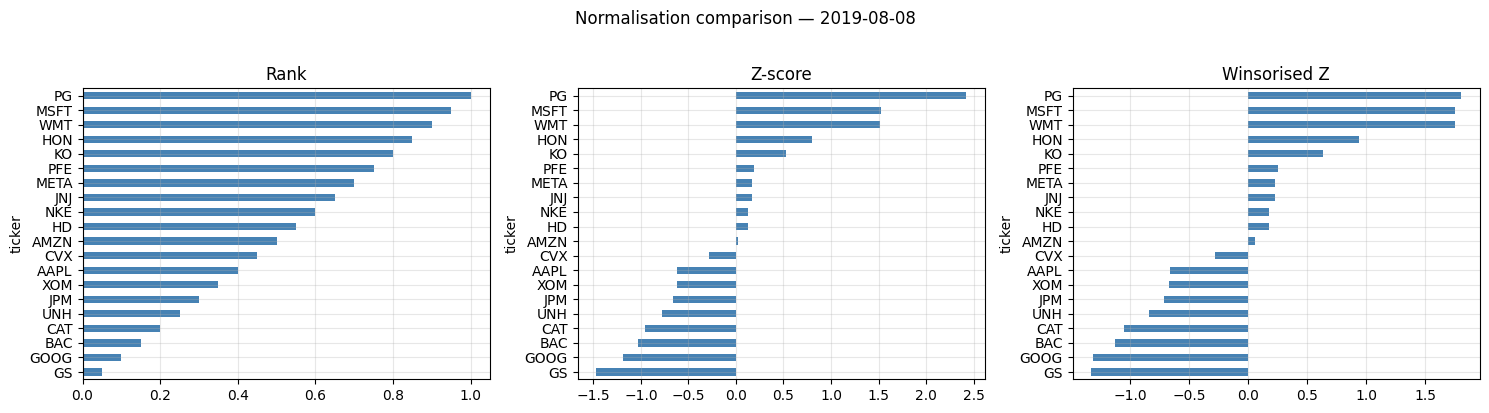

In [4]:
sig_rank = rank(mom_skip.dropna())
sig_zscore = zscore(mom_skip.dropna())
sig_winz = zscore(winsorize(mom_skip.dropna(), lower=0.05, upper=0.95))

d = sig_rank.index.get_level_values("date").unique()[150]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, s) in zip(axes, [("Rank", sig_rank.loc[d]),
                                  ("Z-score", sig_zscore.loc[d]),
                                  ("Winsorised Z", sig_winz.loc[d])]):
    s.sort_values().plot.barh(ax=ax, color="steelblue")
    ax.set_title(name)
plt.suptitle(f"Normalisation comparison — {d.date()}", y=1.02)
plt.tight_layout()
plt.show()

## 4. Portfolio construction

**Quintile long/short**: long top 20%, short bottom 20%, equal weight within each leg.

In [5]:
signal = mom_skip.dropna()
weights = equal_weight_long_short(signal, long_pct=0.2, short_pct=0.2)
weights = normalize_weights(weights, gross_exposure=2.0, net_exposure=0.0)
weights = apply_position_limits(weights, max_weight=0.10, min_weight=-0.10)

net_exp = weights.groupby(level="date").sum()
gross_exp = weights.abs().groupby(level="date").sum()
print(f"Net exposure:   mean={net_exp.mean():.4f}  std={net_exp.std():.4f}")
print(f"Gross exposure: mean={gross_exp.mean():.4f}  std={gross_exp.std():.4f}")
print(f"Positions per date: {(weights != 0).groupby(level='date').sum().mean():.1f}")

Net exposure:   mean=0.1000  std=0.0000
Gross exposure: mean=0.9000  std=0.0000
Positions per date: 18.4


## 5. Backtest

| Step | Timing |
|------|--------|
| Signal observation | Close of day *t* |
| Trades executed | Open of day *t + 1* |

In [6]:
config = BacktestConfig(
    rebalance_freq="monthly", commission_bps=5.0, slippage_bps=5.0,
    signal_lag=1, execution_price="open",
)
result = run_backtest(weights, prices, config=config)
summary = performance_summary(result.portfolio_returns)

print("Momentum backtest — real US equities:")
for k, v in summary.items():
    print(f"  {k:25s}: {v:>10.4f}")

Momentum backtest — real US equities:
  total_return             :     0.1047
  annualized_return        :     0.0144
  annualized_volatility    :     0.1055
  sharpe_ratio             :     0.1361
  sortino_ratio            :     0.1659
  calmar_ratio             :     0.0717
  max_drawdown             :    -0.2004
  hit_rate                 :     0.4352
  profit_factor            :     1.0366
  num_days                 :  1760.0000


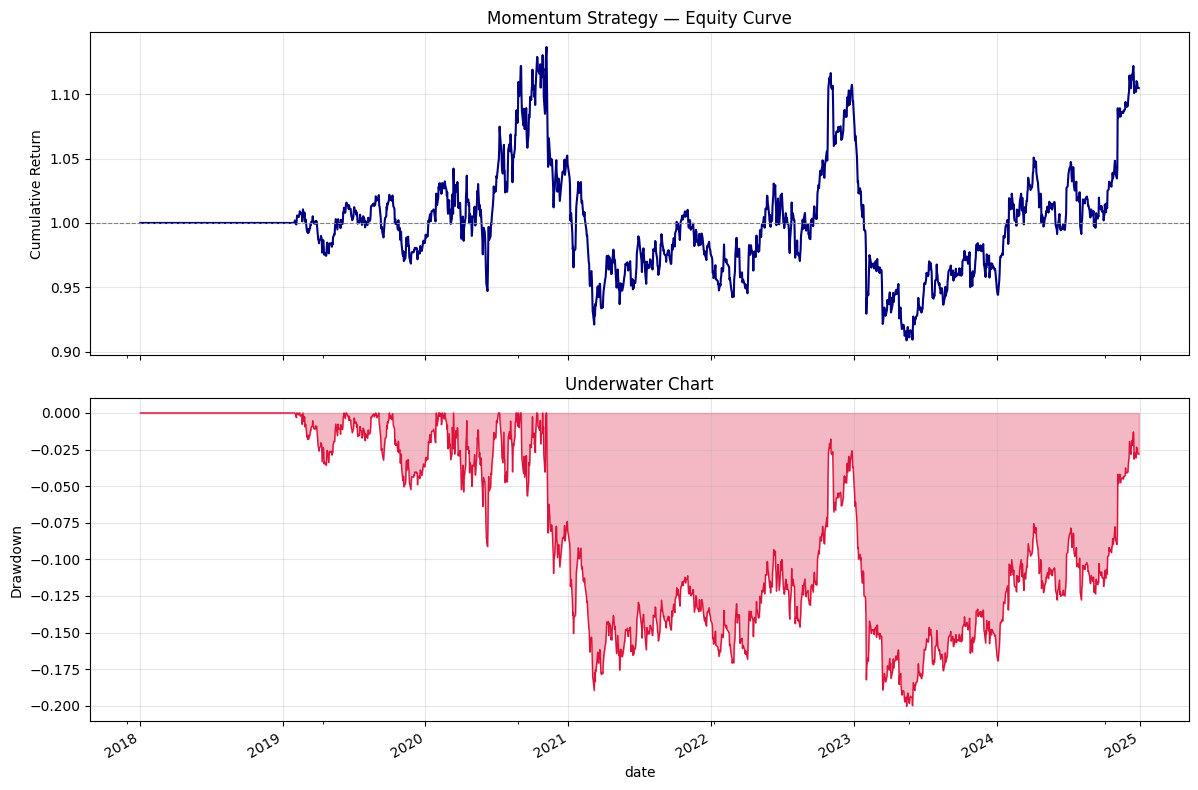

In [7]:
cum_ret = (1 + result.portfolio_returns).cumprod()
dd = drawdown_series(result.portfolio_returns)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
cum_ret.plot(ax=ax1, color="navy", linewidth=1.5)
ax1.set_ylabel("Cumulative Return")
ax1.set_title("Momentum Strategy — Equity Curve")
ax1.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)

dd.plot(ax=ax2, color="crimson", linewidth=1)
ax2.fill_between(dd.index, dd.values, 0, alpha=0.3, color="crimson")
ax2.set_ylabel("Drawdown")
ax2.set_title("Underwater Chart")
plt.tight_layout()
plt.show()

## 6. Drawdown analysis

In [8]:
details = drawdown_details(result.portfolio_returns)
print("Worst 5 drawdown episodes:")
print(details.head(5)[["start", "trough", "depth", "days", "recovery_days"]].to_string())
print(f"\nMax drawdown: {dd.min():.4f}")
print(f"Time in drawdown (>1%): {(dd < -0.01).mean():.1%}")

Worst 5 drawdown episodes:
       start     trough     depth  days  recovery_days
0 2020-11-09 2023-05-16 -0.200421  1040            408
1 2020-03-16 2020-06-08 -0.091261    77             19
2 2020-09-03 2020-09-18 -0.056635    26             16
3 2019-10-02 2019-11-25 -0.052285    81             43
4 2020-07-10 2020-07-23 -0.047542    29             20

Max drawdown: -0.2004
Time in drawdown (>1%): 76.6%


## 7. Cost sensitivity

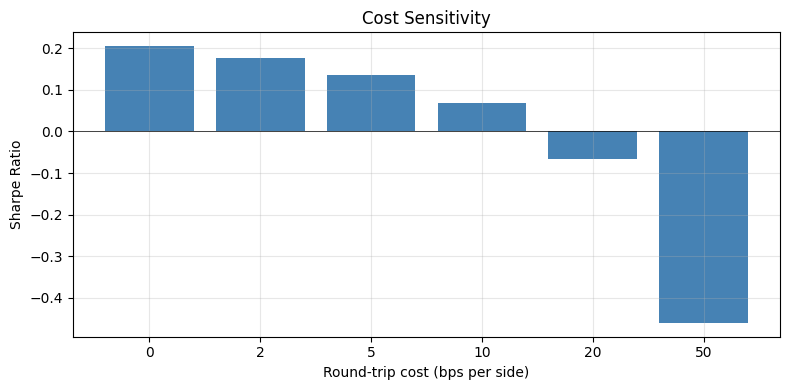

In [9]:
cost_levels = [0, 2, 5, 10, 20, 50]
sharpes = {}
for bps in cost_levels:
    cfg = BacktestConfig(rebalance_freq="monthly", commission_bps=bps,
                         slippage_bps=bps, signal_lag=1, execution_price="open")
    res = run_backtest(weights, prices, config=cfg)
    sharpes[bps] = performance_summary(res.portfolio_returns)["sharpe_ratio"]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([str(b) for b in sharpes.keys()], sharpes.values(), color="steelblue")
ax.set_xlabel("Round-trip cost (bps per side)")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Cost Sensitivity")
ax.axhline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.show()

## 8. Rebalance frequency trade-off

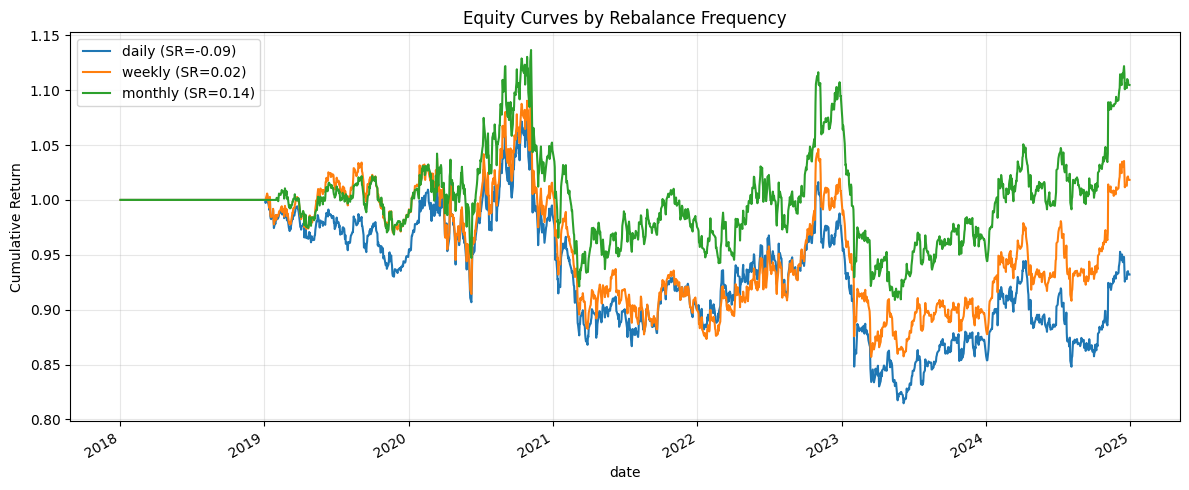

In [10]:
freq_results = {}
for freq in ["daily", "weekly", "monthly"]:
    cfg = BacktestConfig(rebalance_freq=freq, commission_bps=5.0, slippage_bps=5.0,
                         signal_lag=1, execution_price="open")
    res = run_backtest(weights, prices, config=cfg)
    s = performance_summary(res.portfolio_returns)
    cum = (1 + res.portfolio_returns).cumprod()
    freq_results[freq] = {"perf": s, "cum": cum}

fig, ax = plt.subplots(figsize=(12, 5))
for freq, data in freq_results.items():
    data["cum"].plot(ax=ax, label=f"{freq} (SR={data['perf']['sharpe_ratio']:.2f})")
ax.legend()
ax.set_title("Equity Curves by Rebalance Frequency")
ax.set_ylabel("Cumulative Return")
plt.tight_layout()
plt.show()

## 9. What can go wrong

### Momentum crashes
Momentum is exposed to **sharp, convex drawdowns**, especially during market reversals.

### Other risks
- **Crowding**: No backtest detects it — structural market risk.
- **Regime sensitivity**: Momentum works in trending markets, fails in mean-reverting ones.
- **Overfitting**: The 252/21 convention is standard, not optimised. Don't tune on test data.

## 10. Summary

| Concept | Key takeaway |
|---------|-------------|
| Signal | 12-month return minus most recent month |
| Normalisation | Rank or winsorised z-score to tame outliers |
| Portfolio | Quintile long/short, dollar neutral, capped |
| Rebalancing | Monthly balances cost vs freshness |
| Costs | Always run cost sweeps |
| Risk | Crash-prone, regime-dependent |

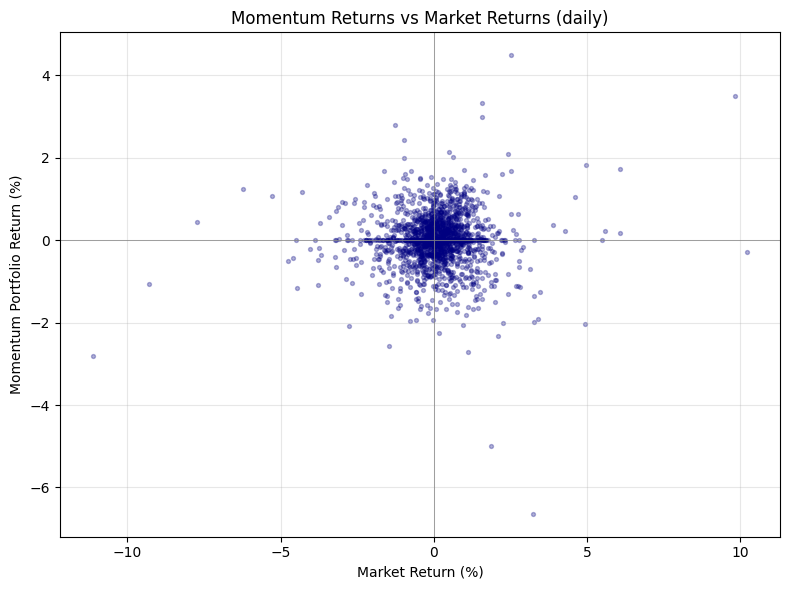

Up-market days   ( 977): ann. mean=+0.056
Down-market days ( 782): ann. mean=-0.025


In [11]:
mkt_ret = simple_returns(close).groupby(level="date").mean().dropna()
port_ret = result.portfolio_returns.reindex(mkt_ret.index).dropna()
mkt_aligned = mkt_ret.reindex(port_ret.index)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(mkt_aligned.values * 100, port_ret.values * 100, alpha=0.3, s=8, color="navy")
ax.axhline(0, color="grey", linewidth=0.5)
ax.axvline(0, color="grey", linewidth=0.5)
ax.set_xlabel("Market Return (%)")
ax.set_ylabel("Momentum Portfolio Return (%)")
ax.set_title("Momentum Returns vs Market Returns (daily)")
plt.tight_layout()
plt.show()

up = port_ret[mkt_aligned > 0]
down = port_ret[mkt_aligned <= 0]
print(f"Up-market days   ({len(up):>4d}): ann. mean={up.mean()*252:+.3f}")
print(f"Down-market days ({len(down):>4d}): ann. mean={down.mean()*252:+.3f}")